In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.7 MB/s eta 0:00:00


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import transformers
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast
device = 'cuda'

In [ ]:
# Import dataset from https://huggingface.co/datasets/badmatr11x/hate-offensive-speech
train = pd.read_parquet('/content/drive/MyDrive/sentiment_analysis/english-offensive-lang-dataset/train-00000-of-00001-b57a122b095e5ed1.parquet')
test  = pd.read_parquet('/content/drive/MyDrive/sentiment_analysis/english-offensive-lang-dataset/test-00000-of-00001-10d11e25d2e9ec6e.parquet')
valid = pd.read_parquet('/content/drive/MyDrive/sentiment_analysis/english-offensive-lang-dataset/validation-00000-of-00001-9ea89a9fc1c6b387.parquet')
frames = [train, test, valid]
df = pd.concat(frames)
df.rename(columns={'tweet':'text'}, inplace=True)
df

,label,text
0,2,where's his other half??? i want to indulge my...
1,2,easier for barrack hussein obama to blame guns...
2,2,As soon as a Democrat gets a chance to ? the p...
3,1,GOOD Music &gt;&gt;&gt;&gt;&gt; Young Money fags
4,2,mass shooting at orlando gay nightclub: what w...
...,...,...
2833,2,@CruzanChoklate look at you with yellow fever.
2834,1,RT @BelowThaaBelt_: Snip snip hoe
2835,1,Who the hell taught you how to fuck bitch toot...
2836,1,&#8220;@NeiAllure: &amp; you should feel disre...


In [ ]:
# Preprocess text
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word == 'RT':
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        elif word.startswith('!') or word.startswith('&') or word.startswith('-'):
            continue
        else:
            final_text += word+' '
    return final_text

df['text'] = df['text'].apply(filter)
df

,label,text
0,2,where's his other half??? i want to indulge my...
1,2,easier for barrack hussein obama to blame guns...
2,2,As soon as a Democrat gets a chance to ? the p...
3,1,GOOD Music Young Money fags
4,2,mass shooting at orlando gay nightclub: what w...
...,...,...
2833,2,look at you with yellow fever.
2834,1,Snip snip hoe
2835,1,Who the hell taught you how to fuck bitch toot...
2836,1,you should feel disrespected if a bitch try to...


In [ ]:
# Labeling offensive and hatespeech as 1
for i in df.index:
    if df.label.iloc[i] == 0 or df.label.iloc[i] == 1:
        df.at[i, 'label'] = 0
    else:
        df.at[i, 'label'] = 1

<Axes: >

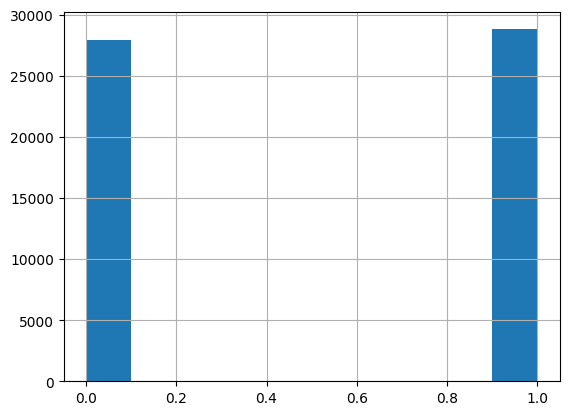

In [ ]:
# Distribution of labels
df.label.hist()

In [ ]:
# Shuffle dataset
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
# Split data into train, test, valid
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
																	random_state = 2021,
																	test_size = 0.2,
																	stratify = df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
																random_state = 2021,
																test_size = 0.5,
																stratify = temp_labels)

In [ ]:
# Import pretrained tokenizer and model from https://huggingface.co/cardiffnlp/twitter-roberta-base-offensive
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")
bert = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-offensive",return_dict=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-offensive were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
#### Create DataLoaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze Model Params and Define Architecture

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class Arch(nn.Module):

    def __init__(self, bert):
      
      super(Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 3 (Output layer)
      self.fc3 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc3(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained model to our define architecture
model = Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.0001)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[1.01520708 0.98524177]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 5

### Fine-tuning

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# Define Early Stopping Function
def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

### Start Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train the model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/english_offensive_language.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Early stopping
    if early_stopping(train_loss, valid_loss, min_delta=10, tolerance = 20):
      print("We are at epoch:", epoch)
      break


 Epoch 1 / 5
  Batch    50  of  1,419.
  Batch   100  of  1,419.
  Batch   150  of  1,419.
  Batch   200  of  1,419.
  Batch   250  of  1,419.
  Batch   300  of  1,419.
  Batch   350  of  1,419.
  Batch   400  of  1,419.
  Batch   450  of  1,419.
  Batch   500  of  1,419.
  Batch   550  of  1,419.
  Batch   600  of  1,419.
  Batch   650  of  1,419.
  Batch   700  of  1,419.
  Batch   750  of  1,419.
  Batch   800  of  1,419.
  Batch   850  of  1,419.
  Batch   900  of  1,419.
  Batch   950  of  1,419.
  Batch 1,000  of  1,419.
  Batch 1,050  of  1,419.
  Batch 1,100  of  1,419.
  Batch 1,150  of  1,419.
  Batch 1,200  of  1,419.
  Batch 1,250  of  1,419.
  Batch 1,300  of  1,419.
  Batch 1,350  of  1,419.
  Batch 1,400  of  1,419.

Evaluating...
  Batch    50  of    178.
  Batch   100  of    178.
  Batch   150  of    178.

Training Loss: 0.402
Validation Loss: 0.382

 Epoch 2 / 5
  Batch    50  of  1,419.
  Batch   100  of  1,419.
  Batch   150  of  1,419.
  Batch   200  of  1,419.
  

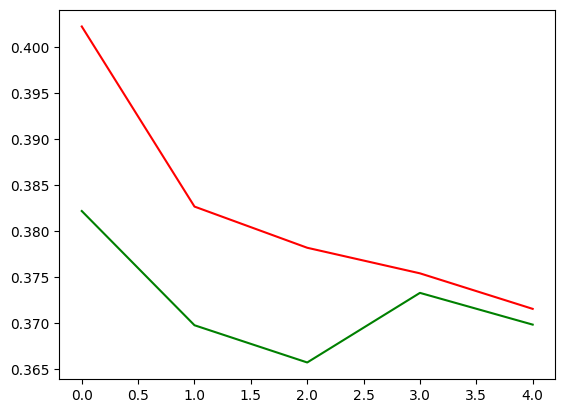

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color='r')
plt.plot(valid_losses, color='g')

### Evaluation

In [ ]:
# confusion matrix
pd.crosstab(test_y, predicted_label)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['OFFENSIVE', 'NOT OFFENSIVE']
print(classification_report(test_y, predicted_label, target_names=target_names))

In [ ]:
# Define predict function
def predict_sentiment(text):
  tokenized = tokenizer.encode_plus(
    text,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
    )

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']

  seq = torch.tensor(input_ids)
  mask = torch.tensor(attention_mask)
  seq = seq.unsqueeze(0)
  mask = mask.unsqueeze(0)
  preds = model(seq, mask)
  preds = preds.detach().cpu().numpy()
  result = np.argmax(preds, axis=1)
  preds = torch.tensor(preds)
  probabilities = nn.functional.softmax(preds)

  return {'OFFENSIVE':float(probabilities[0][1]),
          'NOT OFFENSIVE':float(probabilities[0][0])}